## Fit a polynomial to data

M.R. Fitzsimmons

Version 1.0

12/19/2022

The data should be tab-delimited in a text file.

Meaning of columns:
    
2 columns: abscissa, ordinate
    
3 columns: abscissa, ordinate, standard deviation of ordinate
    
4 columns: abscissa, standard deviation of abscissa, ordinate, standard deviation of ordinate
    
When uncertainties are provided, errors on the fitted parameters are provided.

When uncertainties are provided for abscissa and ordinate values, Orthogonal Distance Regression is used. 
The regression minimizes the distance from a data point to the curve along a segment that is normal to the curve.

The order of the polynomial is set by the user in the next cell as NDeg = an integer.  Use NDeg = 1 for a line.

After selecting a file, the user needs to manually advance the JN to the next cell.

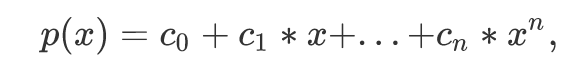

In [1]:
# User should set the value of NDeg to be an integer.
NDeg = 1

In [2]:
%matplotlib notebook

import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.widgets import Slider, Button
from matplotlib.widgets import CheckButtons
from scipy.odr import *

import pandas as pd

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import Label

from tkinter import Tk, filedialog

def poly_func(p, x):
    return np.polynomial.polynomial.polyval(x, p)

def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=False, filetypes=[("Text files","*.txt")]) # List of selected files will be set button's file attribute.
    print(b.files) # Print the list of files selected.


/Users/pookie
Current working directory: /Users/pookie


## Select a file of data

In [3]:
DefaultFilename = cwd_path+'/SomeData.txt'
    
fileselect = widgets.Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

2022-12-19 11:52:46.620 python[17288:4561733] +[CATransaction synchronize] called within transaction
2022-12-19 11:52:50.527 python[17288:4561733] Bad cursor rect event, flags = 0


/Users/pookie/JupyterNotebooks/SimpleFit/SomeDataSigXSigY.txt


## Get the data.

Data should be tab-delimited.

In [4]:
try:
    filename = fileselect.files[:]
    print(filename)
except:
    filename = DefaultFilename
    print('Using default filename: %s'%filename)
    
DataField = pd.read_csv(filename, sep='\t')

NamesOfColumns = list(DataField.columns)

DataArray = DataField.to_numpy()

n = np.shape(DataArray)[0] # number of data points
NumberOfColumns = np.shape(DataArray)[1]

DoSigmaX = False
DoSigmaY = False

X = DataArray[:,0]
Y = DataArray[:,1]
YLabel = NamesOfColumns[1]
if NumberOfColumns == 3:
    DoSigmaY = True
    SigY = DataArray[:,2]

if NumberOfColumns == 4:
    DoSigmaX = True
    DoSigmaY = True
    X = DataArray[:,0]
    SigX = DataArray[:,1]
    Y = DataArray[:,2]
    SigY = DataArray[:,3]
    YLabel = NamesOfColumns[2]
    

/Users/pookie/JupyterNotebooks/SimpleFit/SomeDataSigXSigY.txt


## Fit a model to the data

Uses the new version of polynomial.polyfit, however the new version doesn't 
return the covariance to estimate error on the fitted parameters.

Execute np.polyfit to estimate the errors.  The np.polyfit routine uses coefficients with an order that is
inverted compared to polynomial.polyfit, so the SigCoef gets reversed.  Verified correct by testing with same data using 
very little abscissa error and the ODR.


In [5]:
if not DoSigmaX:
    if DoSigmaY:
        Coef = np.polynomial.polynomial.polyfit(X, Y, NDeg, w = 1/SigY)
        Cdump, Cov = np.polyfit(X, Y, NDeg, w = 1/SigY,cov=True)
        SigCoef = np.flip(np.sqrt(np.diag(Cov)))
    else:
        Coef = np.polynomial.polynomial.polyfit(X, Y, NDeg)
        SigCoef = [0.,0.]
else:
    beta0 = np.polynomial.polynomial.polyfit(X, Y, NDeg, w = 1/SigY) # get estimate usual method
    poly_model = Model(poly_func)
    data = RealData(X, Y, sx = SigX, sy = SigY)
    odr = ODR(data, poly_model, beta0)
    out = odr.run()
#    out.pprint()
    Coef = out.beta
    SigCoef = out.sd_beta
print("\033[1m"+'Values of coefficients and estimates of error.'+"\033[0m")
for i in range(len(Coef)):
    print('%i: %.3e (%.3e)'%(i,Coef[i],SigCoef[i]))
OrdinateFitted = np.polynomial.polynomial.polyval(X,Coef)
        

Values of coefficients and estimates of error.
0: -1.174e-02 (1.647e-01)
1: 2.967e+00 (1.783e-01)


## Plot the data and the fitted model.

<IPython.core.display.Javascript object>


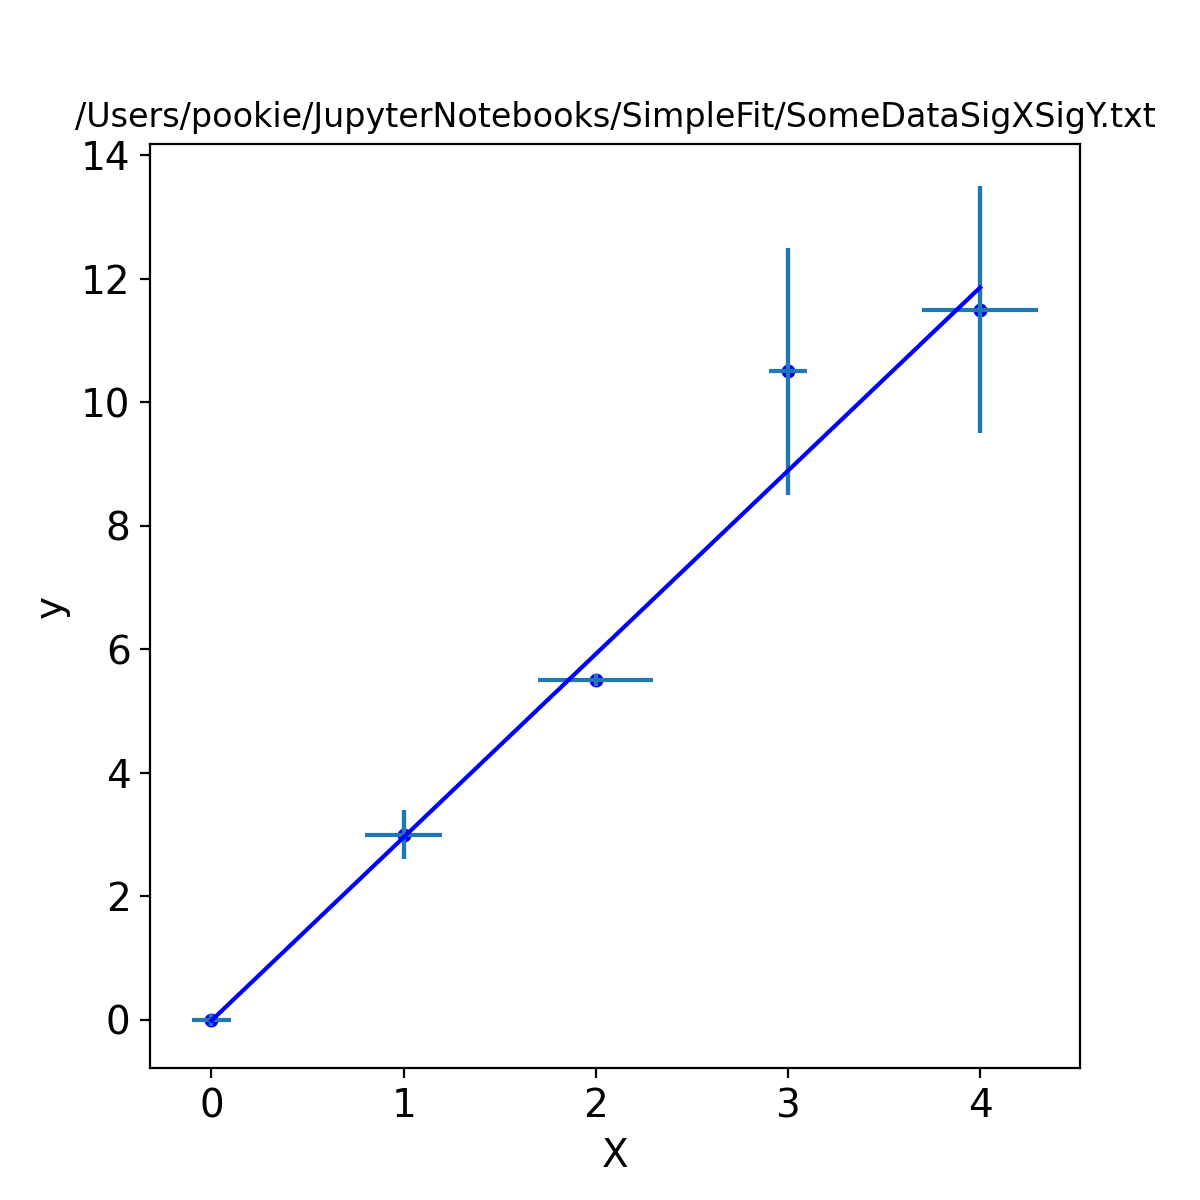

In [6]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (6,6))
plt.title(filename, fontsize=12)
plt.xlabel(NamesOfColumns[0])
plt.ylabel(YLabel)

ax.plot(X, Y,'bo',markersize='4')
if DoSigmaY:
    ax.errorbar(X, Y, yerr=SigY,fmt='none')
if DoSigmaX:
    ax.errorbar(X, Y, yerr=SigY,xerr=SigX,fmt='none')
    
ax.plot(X,OrdinateFitted,'b-')
    
plt.show()
